<a href="https://colab.research.google.com/github/Alimv81/emotion_detection_FER2012/blob/main/emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import albumentations as alb
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
gpu = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)

In [3]:
url = "https://huggingface.co/spaces/mxz/emtion/resolve/c697775e0adc35a9cec32bd4d3484b5f5a263748/fer2013.csv"
df = pd.read_csv(url)

In [4]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
df['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [6]:
df_train = df[df['Usage']=='Training'].copy()
df_test = df[df['Usage']=='PublicTest'].copy()
df_valid = df[df['Usage']=='PrivateTest'].copy()

In [7]:
def split_data(data):
  data['pixels'] = data['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
  images = np.array(data['pixels'].tolist(), dtype='float32').reshape(-1, 48, 48, 1) / 255.0
  images = np.repeat(images, 3, axis=-1)
  labels = data['emotion'].to_numpy()

  return images, labels

In [8]:
train_data, train_labels = split_data(df_train)
test_data, test_labels = split_data(df_test)
validation_data, validation_labels = split_data(df_valid)

In [9]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

In [14]:
from tensorflow.keras.applications import VGG16


base_model = VGG16(input_shape=(48, 48, 3), include_top=False, weights='imagenet')
base_model.trainable = True

In [18]:
from tensorflow.keras.layers import Dense, Conv2D, GlobalMaxPool2D, Flatten, Dropout, MaxPooling2D


model = tf.keras.Sequential([
    base_model,
    GlobalMaxPool2D(),

    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(7, activation='softmax')
])

In [19]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss)

In [20]:
model.fit(datagen.flow(train_data, train_labels, batch_size=32),epochs=25,
                    validation_data=(validation_data, validation_labels))

Epoch 1/25
898/898 [==============================] - 63s 55ms/step - loss: 1.4989 - val_loss: 1.2380
Epoch 2/25
898/898 [==============================] - 43s 48ms/step - loss: 1.2518 - val_loss: 1.1272
Epoch 3/25
898/898 [==============================] - 44s 49ms/step - loss: 1.1649 - val_loss: 1.0749
Epoch 4/25
898/898 [==============================] - 46s 51ms/step - loss: 1.1054 - val_loss: 1.0930
Epoch 5/25
898/898 [==============================] - 47s 52ms/step - loss: 1.0651 - val_loss: 0.9965
Epoch 6/25
898/898 [==============================] - 45s 50ms/step - loss: 1.0321 - val_loss: 1.0155
Epoch 7/25
898/898 [==============================] - 43s 48ms/step - loss: 0.9986 - val_loss: 0.9792
Epoch 8/25
898/898 [==============================] - 44s 49ms/step - loss: 0.9713 - val_loss: 0.9884
Epoch 9/25
898/898 [==============================] - 46s 51ms/step - loss: 0.9421 - val_loss: 1.0124
Epoch 10/25
898/898 [==============================] - 45s 50ms/step - loss: 0.920

In [21]:
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [22]:
predy = model.predict(test_data)

113/113 [==============================] - 1s 11ms/step


In [23]:
predy[0], np.argmax(predy[0])

(array([1.3648156e-02, 5.8167050e-05, 2.5120007e-02, 6.6796809e-01,
        5.6864686e-02, 1.0686505e-02, 2.2565445e-01], dtype=float32),
 3)

In [24]:
from sklearn.metrics import accuracy_score

print(accuracy_score(test_labels, np.argmax(predy, axis=1)))

0.6597938144329897


In [25]:
idx = [12, 456, 1568, 3194]
image_batch = test_data[idx]
label_batch = test_labels[idx]
label_batch_pred = np.argmax(predy[idx], axis=1)

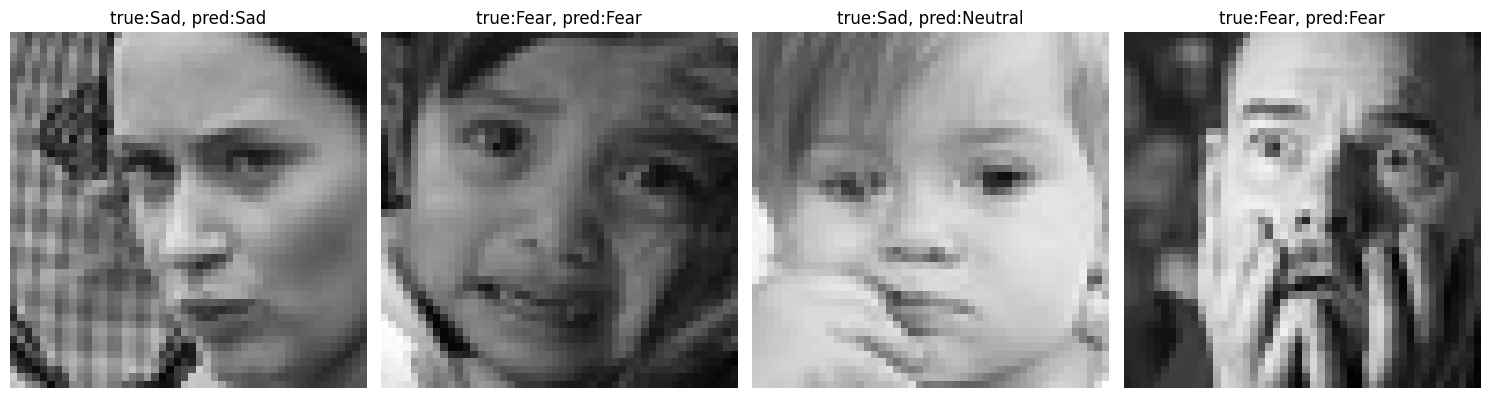

In [26]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

for i, ax in enumerate(axes):
    image = image_batch[i]
    ax.imshow(image)
    ax.set_title(f'true:{emotion_map[label_batch[i]]}, pred:{emotion_map[label_batch_pred[i]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()